# Semeval 2025 Task 10
### Subtask 1: Entity Framing

Given a news article and a list of mentions of named entities (NEs) in the article, assign for each such mention one or more roles using a [predefined taxonomy of fine-grained roles](https://propaganda.math.unipd.it/semeval2025task10/ENTITY-ROLE-TAXONOMY.pdf) covering three main type of roles: protagonists, antagonists, and innocent. This is a multi-label multi-class text-span classification task.

## 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
import seaborn as sns
import os


In [2]:
!pip install InstructorEmbedding

## 2. Reading our data


We will go ahead and start by reading the annotations from the subtask-1.

* The annotations are our ground-truths.
For each article we read it's id, it's entity which is by-default given to us, and the class/sub-class where it belongs to.

In [3]:
raw_annotation_data = []

with open("data/semeval_data/subtask-1-annotations.txt", 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        raw_annotation_data.append(parts)

annotations_df = pd.DataFrame(raw_annotation_data)

In [4]:
annotations_df.head()

,0,1,2,3,4,5,6
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,Spy,None
1,EN_UA_103861.txt,China,1516,1520,Antagonist,Instigator,None
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,Terrorist,None
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,Peacemaker,Guardian
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,Incompetent,None


In [5]:
annotations_df.shape

(414, 7)

For simplicity, we will ignore the `fine-grained_roles` attribute for, as it requires further thinking on how to handle a specific article on having multiple roles.

For now, we will focus on trying to classify each entity on it's `main_role` and then move from there.

We will also rename our labels to represent the actual ones:

In [6]:
annotations_df.rename(columns={0: 'article_id', 1: 'entity_mention', 2: 'start_offset',
                   3: 'end_offset', 4: 'main_role', 5: 'fine_grained_roles',
                   6: 'additional_info'}, inplace=True)

annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,fine_grained_roles,additional_info
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,Spy,None
1,EN_UA_103861.txt,China,1516,1520,Antagonist,Instigator,None
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,Terrorist,None
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,Peacemaker,Guardian
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,Incompetent,None


Notice that in a single article, we can have the same entity mentioned playing different roles:

In [7]:
annotations_df[annotations_df['article_id'] == 'EN_UA_013257.txt']

,article_id,entity_mention,start_offset,end_offset,main_role,fine_grained_roles,additional_info
398,EN_UA_013257.txt,Russia,375,380,Protagonist,Underdog,None
399,EN_UA_013257.txt,Russia,944,949,Innocent,Victim,None
400,EN_UA_013257.txt,Russia,1590,1595,Protagonist,Guardian,None
401,EN_UA_013257.txt,Western countries,1667,1683,Antagonist,Saboteur,None
402,EN_UA_013257.txt,Russia,1763,1768,Protagonist,Virtuous,None


In [8]:
# To be changed, for simplity now
annotations_df.drop(columns=['fine_grained_roles', 'additional_info'], inplace=True)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role
0,EN_UA_103861.txt,Chinese,791,797,Antagonist
1,EN_UA_103861.txt,China,1516,1520,Antagonist
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist
4,EN_UA_021270.txt,Yermak,667,672,Antagonist


Also, notice that in the `article_id` the beginning of it, the `EN_*` part, is irrelevant to us.

We will go ahead and remove it and only keep the id of the article which is the part we actually want.

In [9]:
def extract_article_id(filename):
    number_part = filename.split('_')[-1].split('.')[0]
    return number_part

print(extract_article_id('EN_UA_103861.txt'))

103861


In [10]:
annotations_df['article_id'] = annotations_df['article_id'].apply(extract_article_id)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role
0,103861,Chinese,791,797,Antagonist
1,103861,China,1516,1520,Antagonist
2,103861,Hamas,2121,2125,Antagonist
3,103861,Donald Trump,4909,4920,Protagonist
4,021270,Yermak,667,672,Antagonist


We will know read our actual articles.

In [11]:
def read_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()


We create a placeholder dataframe, that is going to be filled up.

There are 2 columns that we are seeking, the `article_id` and the actual `content` of that.

In [12]:
documents_df = pd.DataFrame(columns=['article_id', 'content'])

In [13]:
folder_path = "data/semeval_data/raw-documents"

for filename in os.listdir(folder_path):
    if filename.endswith('.txt') and filename.startswith('EN'):
        article_id = extract_article_id(filename)
        file_path = os.path.join(folder_path, filename)
        content = read_file_content(file_path)

        new_row = pd.DataFrame({'article_id': [article_id], 'content': [content]})

        documents_df = pd.concat([documents_df, new_row], ignore_index=True)

documents_df.head()

,article_id,content
0,104876,Putin honours army unit blamed for Bucha massa...
1,023211,Europe Putin thanks US journalist Tucker Carls...
2,011260,Russia has a clear plan to resolve the conflic...
3,101067,"First war of TikTok era sees tragedy, humor an..."
4,102963,Ukraine's President Zelenskyy to address Mexic...


There are 200 articles that are given to us for this task:

In [14]:
documents_df.shape

(200, 2)

We then merge our dataframes into a single dataframe constisting.

The derived dataframe has the following columns:

* `article_id`
* `content`
* `entity_mention`
* The entity's starting and ending position in the article
* The ground truth of the entity.

In [15]:
dataset = pd.merge(documents_df, annotations_df, on='article_id')
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist


In [16]:
print(dataset.iloc[4].content)

Russia has a clear plan to resolve the conflict in Ukraine 

 The conflict in Ukraine may end either by diplomatic or military means. However, it can be possible only after Moscow achieves its goals.

"An opportunity to resolve the conflict will appear only when Ukraine ceases to pose a threat to Russia and discriminate against Russian-speaking Ukrainians,” Vasily Nebenzya, Russia's Ambassador to the UN Security Council, said at a briefing at the UN Security Council.

"If this result can be achieved through negotiations, we are ready for such a scenario. If not, then our objectives will be achieved by military means," he added.

Russia is not fighting against the Ukrainian people. Russia is fighting against the criminal nationalist regime that came to power in 2014” after the coup in Kyiv, the diplomat said.

"The new Ukrainian leadership is trying to purge the country of everything connected with Russia and glorify Nazi accomplices. <…>

"The Kyiv regime and its most rabid patrons hav

Since the annotations where limited to `417`, we also expect that the merged dataframe will be of that size:

In [17]:
dataset.shape

(417, 6)

We also do a sanity-check to see if there are any missing values:

In [18]:
dataset.isnull().sum()

article_id        0
content           0
entity_mention    0
start_offset      0
end_offset        0
main_role         0
dtype: int64

Notice that the distributions of roles are uneven, with the `Antagonist` being the most common class, and `Innocent` being the least common.

This should worry us, and we should keep this in mind when attempting to find a good classifier.

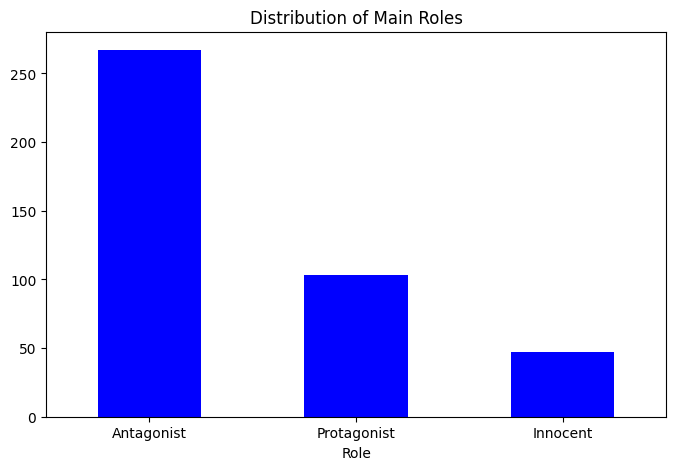

In [19]:
role_counts = dataset['main_role'].value_counts()

plt.figure(figsize=(8, 5))
role_counts.plot(kind='bar', color=['blue'])
plt.title('Distribution of Main Roles')
plt.xlabel('Role')
plt.xticks(rotation=0)
plt.show()

## 3. Preparing our data

We now begin by processing our data and preparing it in order to find a good, initial/baseline classifier for this task.


Our goal is to classify those entities into 3 classes:
* `Protagonist`
* `Antagonist`
* `Innocent`

It's obvious that this task is an instance of a supervised learning, we have some features and we are also given the ground truth, the class where each entity truly belongs to.

We begin by shuffling our data:

In [20]:
random_state = 42 # used for experimentantions
# dataset = dataset.sample(frac=1, random_state=random_state)
dataset = dataset.sample(frac=1)
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role
26,026142,Oppose imperialist War! SEP/IYSSE public meeti...,Zionist,2564,2570,Antagonist
360,022339,"""Aren't They Fools?"": Putin Says Ukrainian Sta...",Russian civilians,1455,1471,Innocent
331,029053,British colonel: Ukrainian operation in Kursk ...,Ayatollah Khamenei,2994,3011,Antagonist
348,024628,"Washington will not let Ukraine fail, US defen...",United States,140,152,Protagonist
312,029155,Head of German Intelligence Reveals Zelensky B...,Volodymyr Zelensky,160,177,Antagonist


In [21]:
print(dataset.iloc[1].content)

"Aren't They Fools?": Putin Says Ukrainian Statehood Risks 'Irreparable Blow' If War Continues 

 "Aren't They Fools?": Putin Says Ukrainian Statehood Risks 'Irreparable Blow' If War Continues

Russian President Vladimir Putin gave statements on Tuesday which assessed the overall status of the nearly two-year conflict with Ukraine at a moment Western and world leaders meet in Davos for the World Economic Forum (WEF). Zelensky while there in Switzerland pressed Ukraine's case for the need to achieve air superiority.

But Putin in his fresh remarks stressed that not only do Russian forces have the clear upper hand, but he emphasized for the first time that Ukrainian statehood itself risks an "irreparable" blow if the war continues. He stressed that Ukraine's military has already "failed".

"Not only has their counteroffensive failed, but the initiative is entirely in the hands of the Russian Armed Forces," Putin said in the televised remarks. "If this continues, Ukraine's statehood could

### 3.1 Training a baseline model

We will begin by seeing how good of a job traditional machine learning models can do for this kind of tasks.

Our idea is simple, since we have the `start_offset` and `end_offset` of each entity, we can also get the nearby x words of that entity surrounding it, before and after:

In [22]:
def get_context(row, window=180):
    content = row['content']
    start = int(row['start_offset'])
    end = int(row['end_offset'])

    words = content.split()

    pre_entity_text = content[:start].split()
    post_entity_text = content[end + 1:].split()

    # Get context words before and after
    context_before = " ".join(pre_entity_text[-window:])
    context_after = " ".join(post_entity_text[:window])

    return context_before, context_after

dataset['context_before'], dataset['context_after'] = zip(*dataset.apply(get_context, axis=1))

In [23]:
example_context = "Moscow: Russia will ask the UN Security Council for an investigation"
entity_mention = "Russia"
start_offset = 8
end_offset = 13

example_df = pd.DataFrame({
    'content': [example_context],
    'entity_mention': [entity_mention],
    'start_offset': [start_offset],
    'end_offset': [end_offset]
})

example_df

,content,entity_mention,start_offset,end_offset
0,Moscow: Russia will ask the UN Security Counci...,Russia,8,13


In [24]:
get_context(example_df.iloc[0])

('Moscow:', 'will ask the UN Security Council for an investigation')

The article in row 1, has the entity mentioned:

In [25]:
dataset.iloc[1].entity_mention

'Russian civilians'

Context before the entity:

In [26]:
dataset.iloc[1].context_before

'moment Western and world leaders meet in Davos for the World Economic Forum (WEF). Zelensky while there in Switzerland pressed Ukraine\'s case for the need to achieve air superiority. But Putin in his fresh remarks stressed that not only do Russian forces have the clear upper hand, but he emphasized for the first time that Ukrainian statehood itself risks an "irreparable" blow if the war continues. He stressed that Ukraine\'s military has already "failed". "Not only has their counteroffensive failed, but the initiative is entirely in the hands of the Russian Armed Forces," Putin said in the televised remarks. "If this continues, Ukraine\'s statehood could be dealt an irreparable, very serious blow," he added, but he didn\'t clarify further precisely what he meant by this. "They are trying to show that they can also do something. But instead of solving military tasks, they act in such a barbaric way. Attacks are being carried out on peaceful settlements with indiscriminate weapons," Pu

Context after the entity:

In [27]:
dataset.iloc[1].context_after

'. Putin further addressed Zelensky\'s efforts to gather world leaders for a peace summit hosted by Switzerland, to consider Kiev\'s 10-point peace plan, which it should be noted rejects the possibility of territorial concessions. "The so-called \'peace formula\' that\'s being talked about in the West and in Ukraine is a continuation of the decree of the Ukrainian president banning negotiations with Russia," Putin said, according to a translation in Sputnik. "As for the negotiating process, it\'s an attempt to encourage us to abandon the territorial gains we\'ve achieved over the past 1 1/2 years. But this is impossible. Everyone understands that this is impossible," the Russian leader continued. He explained that earlier in the conflict, the two sides were close to serious negotiations that could have led to peace, but that ultimately Zelensky allowed himself to be the puppet of Western powers... "A day later, they threw all the agreements into the trash, and now they are saying publi

In [28]:
dataset.iloc[1].main_role

'Innocent'

We also do again a sanity check that our results are correct:

In [29]:
dataset.iloc[1].content

'"Aren\'t They Fools?": Putin Says Ukrainian Statehood Risks \'Irreparable Blow\' If War Continues \n\n "Aren\'t They Fools?": Putin Says Ukrainian Statehood Risks \'Irreparable Blow\' If War Continues\n\nRussian President Vladimir Putin gave statements on Tuesday which assessed the overall status of the nearly two-year conflict with Ukraine at a moment Western and world leaders meet in Davos for the World Economic Forum (WEF). Zelensky while there in Switzerland pressed Ukraine\'s case for the need to achieve air superiority.\n\nBut Putin in his fresh remarks stressed that not only do Russian forces have the clear upper hand, but he emphasized for the first time that Ukrainian statehood itself risks an "irreparable" blow if the war continues. He stressed that Ukraine\'s military has already "failed".\n\n"Not only has their counteroffensive failed, but the initiative is entirely in the hands of the Russian Armed Forces," Putin said in the televised remarks. "If this continues, Ukraine\

We then combine the ccontext before and after the entity to a single, `entity_context`.

In [30]:
dataset['entity_context'] = dataset['context_before'] + " " + dataset['entity_mention'] + " " + dataset['context_after']

In [31]:
dataset.iloc[1].entity_context

'moment Western and world leaders meet in Davos for the World Economic Forum (WEF). Zelensky while there in Switzerland pressed Ukraine\'s case for the need to achieve air superiority. But Putin in his fresh remarks stressed that not only do Russian forces have the clear upper hand, but he emphasized for the first time that Ukrainian statehood itself risks an "irreparable" blow if the war continues. He stressed that Ukraine\'s military has already "failed". "Not only has their counteroffensive failed, but the initiative is entirely in the hands of the Russian Armed Forces," Putin said in the televised remarks. "If this continues, Ukraine\'s statehood could be dealt an irreparable, very serious blow," he added, but he didn\'t clarify further precisely what he meant by this. "They are trying to show that they can also do something. But instead of solving military tasks, they act in such a barbaric way. Attacks are being carried out on peaceful settlements with indiscriminate weapons," Pu

In [32]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,context_before,context_after,entity_context
26,026142,Oppose imperialist War! SEP/IYSSE public meeti...,Zionist,2564,2570,Antagonist,their policies are not simply the product of d...,regime and its imperialist backers have not on...,their policies are not simply the product of d...
360,022339,"""Aren't They Fools?"": Putin Says Ukrainian Sta...",Russian civilians,1455,1471,Innocent,moment Western and world leaders meet in Davos...,. Putin further addressed Zelensky's efforts t...,moment Western and world leaders meet in Davos...
331,029053,British colonel: Ukrainian operation in Kursk ...,Ayatollah Khamenei,2994,3011,Antagonist,lines turned out to be nothing more than basel...,from pushing the button and launching Iran's e...,lines turned out to be nothing more than basel...
348,024628,"Washington will not let Ukraine fail, US defen...",United States,140,152,Protagonist,"Washington will not let Ukraine fail, US defen...",will not let Ukraine fail in fighting off Russ...,"Washington will not let Ukraine fail, US defen..."
312,029155,Head of German Intelligence Reveals Zelensky B...,Volodymyr Zelensky,160,177,Antagonist,Head of German Intelligence Reveals Zelensky B...,and President of Poland both collaborated to c...,Head of German Intelligence Reveals Zelensky B...


In [33]:
!pip -q install emoji
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [34]:
import spacy
import re
import emoji

nlp = spacy.load("en_core_web_sm")

def clean_article(article_text):
    # Remove URLs
    article_text = re.sub(r'http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.com', '', article_text, flags=re.MULTILINE)

    doc = nlp(article_text)
    cleaned_tokens = []

    for token in doc:
        if (token.is_space or '@' in token.text or emoji.is_emoji(token.text)):
            continue

        cleaned_tokens.append(token.text + token.whitespace_)

    cleaned_article = "".join(cleaned_tokens).strip()

    return cleaned_article

In [35]:
dataset['entity_context'] = dataset['entity_context'].apply(clean_article)
dataset.iloc[3].entity_context

'Washington will not let Ukraine fail, US defence chief vows RAMSTEIN AIR BASE - Defense Secretary Lloyd Austin promised Tuesday that the United States will not let Ukraine fail in fighting off Russia, even as further aid remains stalled in Congress and Kyiv’s forces face shortages of munitions. The Republican-led House of Representatives has been blocking $60 billion in assistance for Ukraine and the United States has warned that a recent $300 million package would only last a few weeks. The “United States will not let Ukraine fail”, Austin said at the opening of a meeting in Germany of Ukraine’s international supporters, at which he is seeking to secure further assistance for Kyiv. “We remain determined to provide Ukraine with the resources that it needs to resist the Kremlin’s aggression,” he said. Washington announced $300 million in assistance for Ukraine last week, but Austin said it was only possible due to savings on recent purchases. “We were only able to support this much-nee

In [36]:
dataset.iloc[1].entity_context

'moment Western and world leaders meet in Davos for the World Economic Forum (WEF). Zelensky while there in Switzerland pressed Ukraine\'s case for the need to achieve air superiority. But Putin in his fresh remarks stressed that not only do Russian forces have the clear upper hand, but he emphasized for the first time that Ukrainian statehood itself risks an "irreparable" blow if the war continues. He stressed that Ukraine\'s military has already "failed". "Not only has their counteroffensive failed, but the initiative is entirely in the hands of the Russian Armed Forces," Putin said in the televised remarks. "If this continues, Ukraine\'s statehood could be dealt an irreparable, very serious blow," he added, but he didn\'t clarify further precisely what he meant by this. "They are trying to show that they can also do something. But instead of solving military tasks, they act in such a barbaric way. Attacks are being carried out on peaceful settlements with indiscriminate weapons," Pu

In [37]:
dataset.iloc[3]

article_id                                                   024628
content           Washington will not let Ukraine fail, US defen...
entity_mention                                        United States
start_offset                                                    140
end_offset                                                      152
main_role                                               Protagonist
context_before    Washington will not let Ukraine fail, US defen...
context_after     will not let Ukraine fail in fighting off Russ...
entity_context    Washington will not let Ukraine fail, US defen...
Name: 348, dtype: object

In [38]:
dataset['entity_context'].iloc[4]

'Head of German Intelligence Reveals Zelensky Behind Nord Stream Pipeline Attack The former head of German intelligence has revealed that Ukrainian President Volodymyr Zelensky and President of Poland both collaborated to carry out the attack on the Nord Stream Pipelines. The Nord Stream 1 and 2 pipelines were sabotaged on 26 September 2022 after a series of underwater explosions and gas leaks. BYPASS THE CENSORS Sign up to get unfiltered news delivered straight to your inbox. You can unsubscribe any time. By subscribing you agree to our Terms of Use Latest Video Modernity.news reports: Much of the legacy media initially blamed Russia for attack, claiming it was a false flag but offering no sensible reason as to why Moscow would target its own energy infrastructure. However, during an appearance on German broadcaster WELT-TV, August Hanning, who served as the head of Germany’s Federal Intelligence Service (BND) from 1998 to 2005, the attack was carried out at the behest of Zelensky and

In [39]:
dataset['main_role'].iloc[4]

'Antagonist'

In [40]:
dataset['entity_mention'].iloc[4]

'Volodymyr Zelensky'

In [41]:
from sklearn.preprocessing import LabelEncoder

_le = LabelEncoder()
dataset['main_role_encoded'] = _le.fit_transform(dataset['main_role'])

In [42]:
dataset['main_role_encoded']

26     0
360    1
331    0
348    2
312    0
      ..
137    0
28     0
10     0
330    2
174    2
Name: main_role_encoded, Length: 417, dtype: int64

In [43]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_temp = train_test_split(dataset, train_size=0.85, shuffle=True, stratify=dataset['main_role_encoded'])

In [44]:
dataset_val, dataset_test = train_test_split(dataset_temp, train_size=0.5, shuffle=True, stratify=dataset_temp['main_role_encoded'])

In [45]:
dataset_test.main_role.value_counts()

main_role
Antagonist     20
Protagonist     8
Innocent        4
Name: count, dtype: int64

In [46]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

def get_classification_report(y_true, y_pred):
  # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return conf_matrix

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, x, y_true):
  y_pred = model.predict(x)
  classification_report_df = get_classification_report(y_true, y_pred)
  print(classification_report_df)
  print('\n')
  conf = plot_confusion_matrix(y_true, y_pred)
  return conf

def get_cross_val_score(model, x, y, scoring='f1_macro', splits=3):
  cv = StratifiedKFold(n_splits=splits, shuffle=True)
  cross_val_scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
  print(f"Cross-validation scores: {cross_val_scores}")
  print(f"Mean CV F1 Score: {cross_val_scores.mean()}")

In [48]:
import os

def embeddings_exist(embeddings_path):
    embeddings_files = [
        'train_embeddings.npy',
        'val_embeddings.npy',
        'test_embeddings.npy',
    ]
    # Check if all required embedding files exist
    for embedding_file in embeddings_files:
        path = os.path.join(embeddings_path, embedding_file) 
        if not os.path.exists(path):
            return False
    return True


In [49]:
model = None

embeddings_dir = '/content/data/embeddings/entity_framing/'
os.makedirs(embedding_dir, exist_ok=True)

if not embeddings_exist(embeddings_dir):
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("hkunlp/instructor-large")

pytorch_model.bin:  63%|######3   | 849M/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

In [50]:
import numpy as np

def save_embeddings(embeddings, file_path):
    np.save(file_path, embeddings)
    print(f"Embeddings saved to {file_path}")

def get_instructor_embeddings(dataset, model, file_path=None):
    if file_path and os.path.exists(file_path):
        print(f"Loading embeddings from {file_path}")
        return np.load(file_path)

    embeddings = []
    for index, row in dataset.iterrows():
        entity = row['entity_mention']
        context = row['entity_context']
        instruction = (
            f"Classify the role of {entity} in this context as antagonist, protagonist, or innocent. Focus on their "
            f"actions, intent, and surrounding sentiment: "
        )
        embedding = model.encode([[instruction, context]])
        embeddings.append(embedding[0])

    embeddings = np.array(embeddings)

    if file_path:
        save_embeddings(embeddings, file_path)

    return embeddings

In [51]:
train_embeddings_path = os.path.join(embedding_dir, 'train_embeddings.npy')
val_embeddings_path = os.path.join(embedding_dir, 'val_embeddings.npy')
test_embeddings_path = os.path.join(embedding_dir, 'test_embeddings.npy')

def load_embeddings(file_path):
  if os.path.exists(file_path):
      print(f"Loading embeddings from {file_path}")
      return np.load(file_path)
  else:
      print(f"No embeddings found at {file_path}")
      return None

def ensure_embeddings(dataset, model, dataset_type='train'):
    if dataset_type == 'train':
        embeddings_path = train_embeddings_path
    elif dataset_type == 'val':
        embeddings_path = val_embeddings_path
    elif dataset_type == 'test':
        embeddings_path = test_embeddings_path
    else:
        print('Dataset type must be either train, val or test')
        return

    embeddings = load_embeddings(embeddings_path)

    if embeddings is None:
        print(f"Generating {dataset_type} embeddings...")
        embeddings = get_instructor_embeddings(dataset, model)
        save_embeddings(embeddings, embeddings_path)

    return embeddings

In [52]:
train_x_embeddings = ensure_embeddings(dataset_train, model, dataset_type='train')
val_x_embeddings = ensure_embeddings(dataset_val, model, dataset_type='val')

No embeddings found at data/embeddings/entity_framing/train_embeddings.npy
Generating train embeddings...
Embeddings saved to data/embeddings/entity_framing/train_embeddings.npy
No embeddings found at data/embeddings/entity_framing/val_embeddings.npy
Generating val embeddings...
Embeddings saved to data/embeddings/entity_framing/val_embeddings.npy


In [53]:
train_x_embeddings.shape

(354, 768)

In [54]:
train_x_embeddings[0][:20]

array([-0.03184541,  0.00539773, -0.01247957,  0.02696143,  0.06375494,
        0.01744367,  0.0023281 ,  0.01576601, -0.04076713,  0.04965216,
        0.05956427, -0.02206425,  0.03178336,  0.02601592, -0.03241005,
       -0.02916206, -0.04596349,  0.03148263, -0.02311569, -0.00073449],
      dtype=float32)

In [55]:
train_y_encoded = dataset_train['main_role_encoded'].reset_index(drop=True)
val_y_encoded = dataset_val['main_role_encoded'].reset_index(drop=True)

train_y_encoded

0      0
1      1
2      0
3      0
4      2
      ..
349    0
350    2
351    0
352    0
353    0
Name: main_role_encoded, Length: 354, dtype: int64

In [56]:
test_x_embeddings = ensure_embeddings(dataset_test, model, dataset_type='test')
test_y_encoded = dataset_test['main_role_encoded'].reset_index(drop=True)

No embeddings found at data/embeddings/entity_framing/test_embeddings.npy
Generating test embeddings...
Embeddings saved to data/embeddings/entity_framing/test_embeddings.npy


In [57]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
get_cross_val_score(knn_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.42712843 0.4437157  0.40781893]
Mean CV F1 Score: 0.4262210182769193


              precision    recall  f1-score    support
0              0.727273  0.800000  0.761905  20.000000
1              0.142857  0.333333  0.200000   3.000000
2              1.000000  0.250000  0.400000   8.000000
accuracy       0.612903  0.612903  0.612903   0.612903
macro avg      0.623377  0.461111  0.453968  31.000000
weighted avg   0.741098  0.612903  0.614132  31.000000




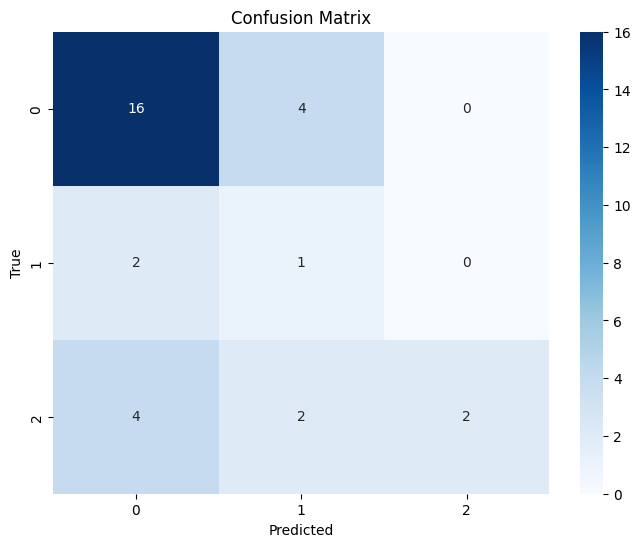

array([[16,  4,  0],
       [ 2,  1,  0],
       [ 4,  2,  2]])

In [58]:
knn_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(knn_classifier, val_x_embeddings, val_y_encoded)

In [59]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=150)
get_cross_val_score(xgb_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.43699856 0.42152429 0.39278683]
Mean CV F1 Score: 0.41710322786720955


              precision    recall  f1-score    support
0              0.652174  0.750000  0.697674  20.000000
1              0.200000  0.333333  0.250000   3.000000
2              0.666667  0.250000  0.363636   8.000000
accuracy       0.580645  0.580645  0.580645   0.580645
macro avg      0.506280  0.444444  0.437104  31.000000
weighted avg   0.612155  0.580645  0.568148  31.000000




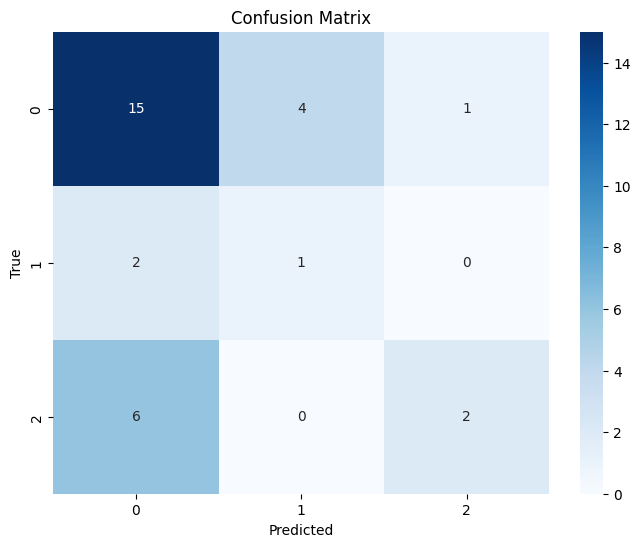

array([[15,  4,  1],
       [ 2,  1,  0],
       [ 6,  0,  2]])

In [60]:
xgb_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(xgb_classifier, val_x_embeddings, val_y_encoded)

In [61]:
label = _le.inverse_transform([1])
print(label)

['Innocent']


In [62]:
from collections import Counter
Counter(train_y_encoded)

Counter({0: 227, 2: 87, 1: 40})

In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_depth=5)
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=100, learning_rate=.1)

get_cross_val_score(adaboost_classifier, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-validation scores: [0.39969009 0.44991648 0.42071795]
Mean CV F1 Score: 0.4234415074518907


In [64]:
adaboost_classifier.fit(train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=100)

              precision    recall  f1-score    support
0              0.615385  0.800000  0.695652  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              1.000000  0.125000  0.222222   8.000000
accuracy       0.548387  0.548387  0.548387   0.548387
macro avg      0.538462  0.308333  0.305958  31.000000
weighted avg   0.655087  0.548387  0.506156  31.000000




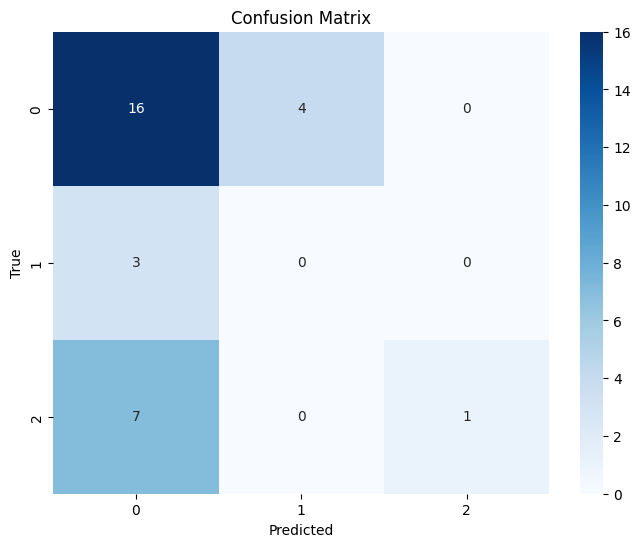

array([[16,  4,  0],
       [ 3,  0,  0],
       [ 7,  0,  1]])

In [65]:
evaluate_model(adaboost_classifier, val_x_embeddings, val_y_encoded)

In [66]:
from sklearn.utils import class_weight

classes = np.unique(train_y_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_y_encoded)
class_weights

array([0.51982379, 2.95      , 1.35632184])

In [67]:
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 0.5198237885462555, 1: 2.95, 2: 1.3563218390804597}

In [68]:
custom_class_weights = {
    0: 0.5,  # Antagonist
    1: 3.5,  # Innocent (increased from 2.95)
    2: 1.5   # Protagonist (slightly increased)
}

In [69]:
sample_weights = np.array([custom_class_weights[label] for label in train_y_encoded])

In [70]:
sample_weights

array([0.5, 3.5, 0.5, 0.5, 1.5, 0.5, 0.5, 3.5, 0.5, 1.5, 0.5, 1.5, 0.5,
       0.5, 1.5, 0.5, 1.5, 3.5, 3.5, 3.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5,
       1.5, 1.5, 0.5, 3.5, 0.5, 0.5, 0.5, 0.5, 1.5, 3.5, 0.5, 0.5, 1.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 3.5, 1.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 1.5, 1.5, 1.5, 0.5, 0.5, 3.5, 0.5, 0.5, 3.5, 0.5, 0.5,
       1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 3.5, 1.5, 3.5, 1.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 1.5, 0.5, 3.5, 0.5, 0.5, 0.5,
       0.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 1.5,
       3.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5,
       0.5, 0.5, 3.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5,
       1.5, 0.5, 3.5, 1.5, 1.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5, 1.5, 0.5,
       0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 1.

In [71]:
import xgboost as xgb

xgb_weighted = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150)
get_cross_val_score(xgb_weighted, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.38708688 0.45833333 0.41882603]
Mean CV F1 Score: 0.42141541541990724


              precision    recall  f1-score    support
0              0.714286  0.750000  0.731707  20.000000
1              0.142857  0.333333  0.200000   3.000000
2              1.000000  0.375000  0.545455   8.000000
accuracy       0.612903  0.612903  0.612903   0.612903
macro avg      0.619048  0.486111  0.492387  31.000000
weighted avg   0.732719  0.612903  0.632187  31.000000




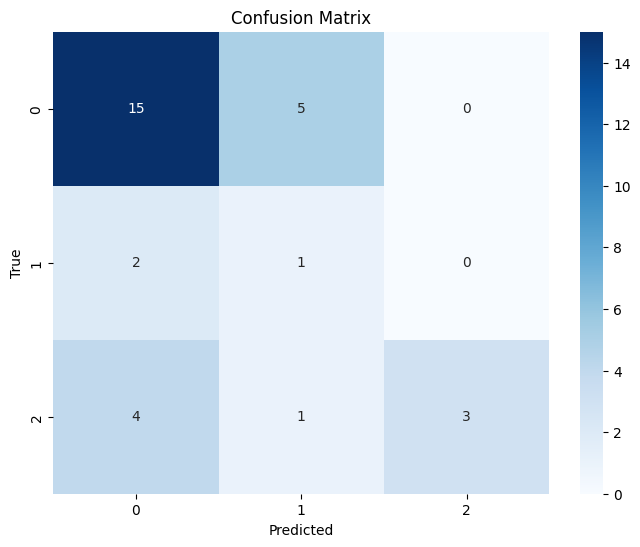

array([[15,  5,  0],
       [ 2,  1,  0],
       [ 4,  1,  3]])

In [72]:
xgb_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)
evaluate_model(xgb_weighted, val_x_embeddings, val_y_encoded)

In [73]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

decision_tree_weighted = DecisionTreeClassifier(max_depth=5, class_weight=custom_class_weights)
adaboost_weighted = AdaBoostClassifier(estimator=decision_tree_weighted, n_estimators=150, learning_rate=.1)
get_cross_val_score(adaboost_weighted, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-validation scores: [0.41700185 0.37002096 0.35789839]
Mean CV F1 Score: 0.38164040381372


In [74]:
adaboost_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                  1: 3.5,
                                                                  2: 1.5},
                                                    max_depth=5),
                   learning_rate=0.1, n_estimators=150)

              precision    recall  f1-score    support
0              0.782609  0.900000  0.837209  20.000000
1              0.333333  0.666667  0.444444   3.000000
2              1.000000  0.250000  0.400000   8.000000
accuracy       0.709677  0.709677  0.709677   0.709677
macro avg      0.705314  0.605556  0.560551  31.000000
weighted avg   0.795231  0.709677  0.686372  31.000000




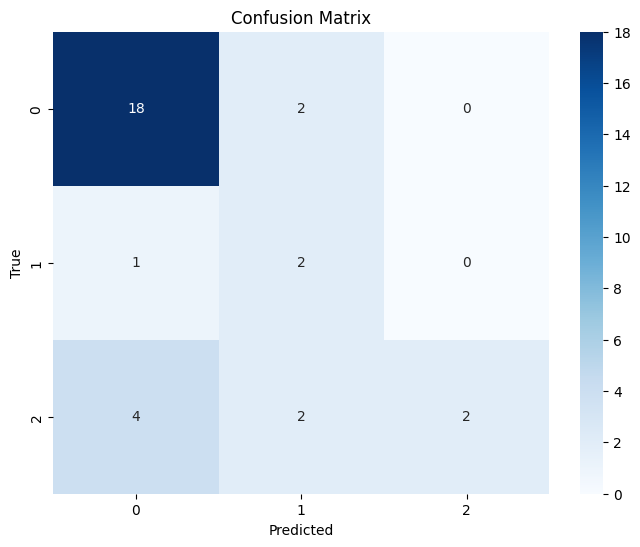

array([[18,  2,  0],
       [ 1,  2,  0],
       [ 4,  2,  2]])

In [75]:
evaluate_model(adaboost_weighted, val_x_embeddings, val_y_encoded)

In [76]:
from sklearn.svm import SVC

svm_classifier = SVC(C=10, gamma='scale', kernel='rbf') # attributes after running GridSearch
svm_classifier.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

SVC(C=10)

In [77]:
get_cross_val_score(svm_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.38436456 0.41709689 0.43377679]
Mean CV F1 Score: 0.4117460779460189


              precision    recall  f1-score    support
0              0.636364  0.350000  0.451613  20.000000
1              0.166667  0.666667  0.266667   3.000000
2              0.375000  0.375000  0.375000   8.000000
accuracy       0.387097  0.387097  0.387097   0.387097
macro avg      0.392677  0.463889  0.364427  31.000000
weighted avg   0.523460  0.387097  0.413944  31.000000




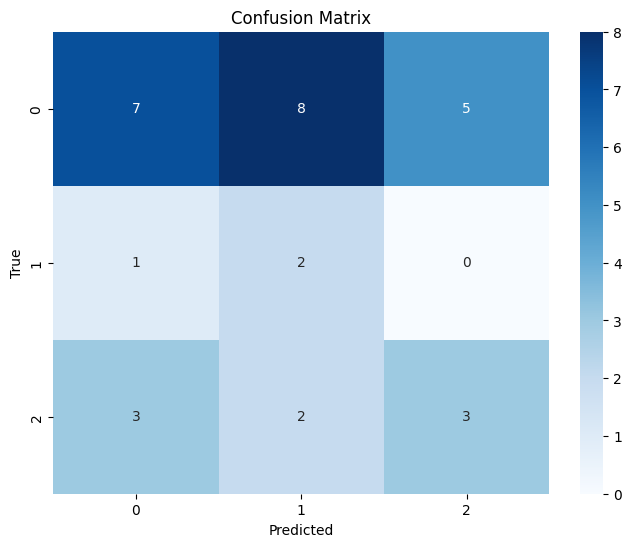

array([[7, 8, 5],
       [1, 2, 0],
       [3, 2, 3]])

In [78]:
evaluate_model(svm_classifier, val_x_embeddings, val_y_encoded)

In [80]:
classes = len(np.unique(train_y_encoded))

embedding_dim = train_x_embeddings.shape[1]

small_model = tf.keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(embedding_dim,)),
    keras.layers.Dense(classes, activation='softmax')
])

In [81]:
def compile_and_fit(x_train, y_train, model, optimizer=None, max_epochs=100, callbacks=[], lr=0.01, use_class_weights=False):
    if not optimizer:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        epochs=max_epochs,
        validation_data=(val_x_embeddings, val_y_encoded),
        callbacks=callbacks,
        verbose=2,
        class_weight=class_weights_dict if use_class_weights else None
    )
    return history

In [82]:
def plot_history(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def evaluate_mlp(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=-1)

    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [83]:
hist_small = compile_and_fit(train_x_embeddings, train_y_encoded, small_model)

Epoch 1/100
12/12 - 0s - loss: 0.9326 - accuracy: 0.5650 - val_loss: 0.9055 - val_accuracy: 0.6452 - 243ms/epoch - 20ms/step
Epoch 2/100
12/12 - 0s - loss: 0.9192 - accuracy: 0.6412 - val_loss: 0.8653 - val_accuracy: 0.6452 - 9ms/epoch - 762us/step
Epoch 3/100
12/12 - 0s - loss: 0.8663 - accuracy: 0.6412 - val_loss: 0.8623 - val_accuracy: 0.6452 - 9ms/epoch - 732us/step
Epoch 4/100
12/12 - 0s - loss: 0.8574 - accuracy: 0.6412 - val_loss: 0.8556 - val_accuracy: 0.6452 - 9ms/epoch - 752us/step
Epoch 5/100
12/12 - 0s - loss: 0.8463 - accuracy: 0.6412 - val_loss: 0.8600 - val_accuracy: 0.6452 - 13ms/epoch - 1ms/step
Epoch 6/100
12/12 - 0s - loss: 0.8523 - accuracy: 0.6412 - val_loss: 0.8582 - val_accuracy: 0.6452 - 11ms/epoch - 883us/step
Epoch 7/100
12/12 - 0s - loss: 0.8579 - accuracy: 0.6441 - val_loss: 0.8860 - val_accuracy: 0.6452 - 12ms/epoch - 1ms/step
Epoch 8/100
12/12 - 0s - loss: 0.8399 - accuracy: 0.6412 - val_loss: 0.8556 - val_accuracy: 0.6452 - 11ms/epoch - 939us/step
Epoch 9

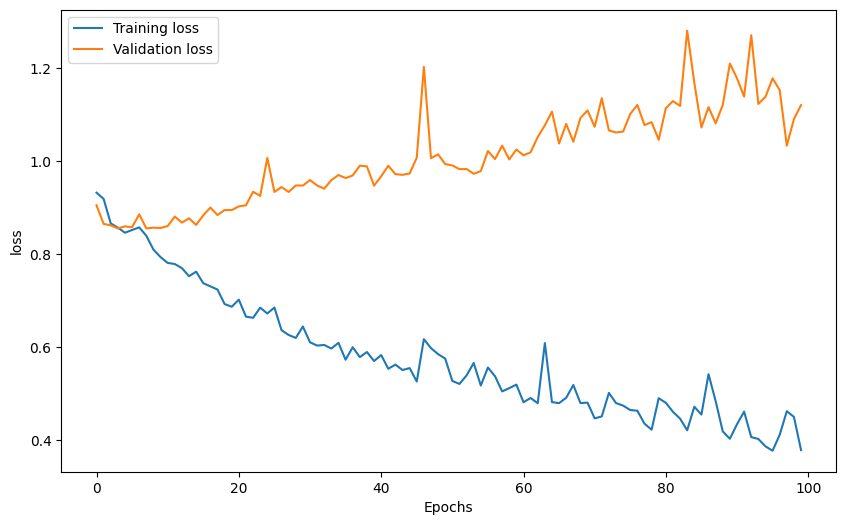

In [84]:
plot_history(hist_small)

1/1 [==============================] - 0s 33ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.40      0.67      0.50         3
           2       0.50      0.38      0.43         8

    accuracy                           0.65        31
   macro avg       0.55      0.60      0.56        31
weighted avg       0.65      0.65      0.64        31

Confusion Matrix:


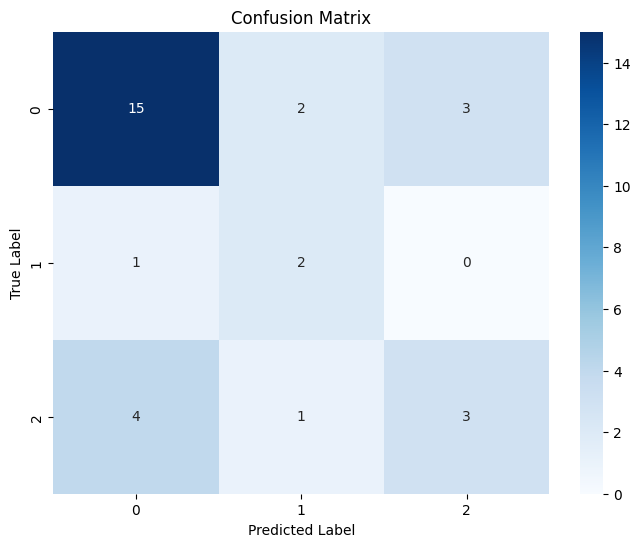

In [85]:
evaluate_mlp(small_model, val_x_embeddings, val_y_encoded)

In [86]:
import time

def pause():
    try:
      while True:
          time.sleep(60)
    except KeyboardInterrupt:
      print("Stopped")


In [ ]:
# pause()